In [47]:
%config InlineBackend.figure_format = "retina"

import os                        
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive


NUM_CPUS = int(os.environ.get("NUM_CPUS", os.cpu_count()))
numpyro.set_host_device_count(NUM_CPUS)

# set a random seed
seed = random.PRNGKey(42)

In [2]:
ys = [9.3, 3.0, 0.7, 11.3, 3.3, 2.3, 14.9, 0.2, 29.5, 16.2]

In [13]:
def model(ys=None):
    # prior
    beta = numpyro.sample("beta", dist.Gamma(3.5, 0.225))
    
    # likelihood
    numpyro.sample("y", dist.Exponential(1.0 / beta), obs=ys)

In [24]:
transition_kernel = NUTS(model)
mcmc = MCMC(transition_kernel, num_warmup=2000, num_samples=10_000, num_chains=NUM_CPUS)
mcmc.run(seed, ys=jnp.array(ys)) # this will generate samples for the posterior of beta

In [25]:
# extract the samples
beta_samples = mcmc.get_samples()["beta"]

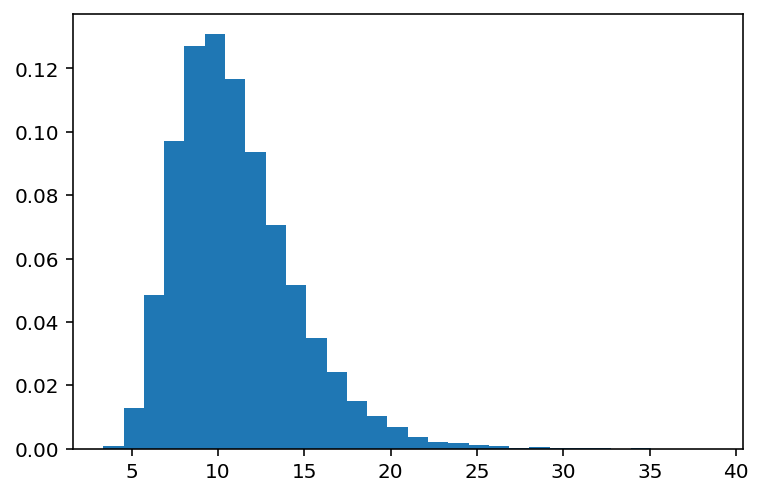

In [26]:
# You can see that the approximate distribution looks like what we obtained analytically by doing integrals
plt.hist(beta_samples, bins=30, density=True)
plt.show()

### Expected value

In [27]:
jnp.mean(beta_samples)

DeviceArray(11.057275, dtype=float32)

### Larger than 30?

In [28]:
jnp.mean(beta_samples > 30)

DeviceArray(0.000375, dtype=float32)

### Between 8 and 12 ?

In [30]:
def between(x, low, high):
    return jnp.logical_and(low < x, x < high)

In [31]:
jnp.mean(between(beta_samples, 8, 12))

DeviceArray(0.488475, dtype=float32)

# Pfizer Vaccine efficacy 

In [57]:
n_treatment = 21_720
n_placebo = 21_728
positive_cases_treatment = 8
positive_cases_placebo = 162

def model(n_treatmetn, n_placebo, cases_treatment, cases_placebo):
    # --- priors
    # --- important: we don't assume different priors for treatment and placebo groups
    theta_treatment = numpyro.sample("theta_treatment", dist.Beta(0.700102, 1))
    theta_placebo = numpyro.sample("theta_placebo", dist.Beta(0.700102, 1))
    
    # --- likelihoods
    numpyro.sample("cases_treatment", dist.Binomial(n_treatment, theta_treatment), obs=cases_treatment)
    numpyro.sample("cases_placebo", dist.Binomial(n_placebo, theta_placebo), obs=cases_placebo)
    
    # --- derived quantities
    numpyro.deterministic("efficacy", 1 - theta_treatment / theta_placebo)

In [58]:
# This is a very important question that demands high precision results. Therefore we use an unusually large number of samples
mcmc = MCMC(NUTS(model), num_warmup=2000, num_samples=100_000, num_chains=NUM_CPUS)
mcmc.run(
    seed,
    n_treatment,
    n_placebo,
    positive_cases_treatment,
    positive_cases_placebo,
)

In [59]:
efficacy = mcmc.get_samples()["efficacy"]

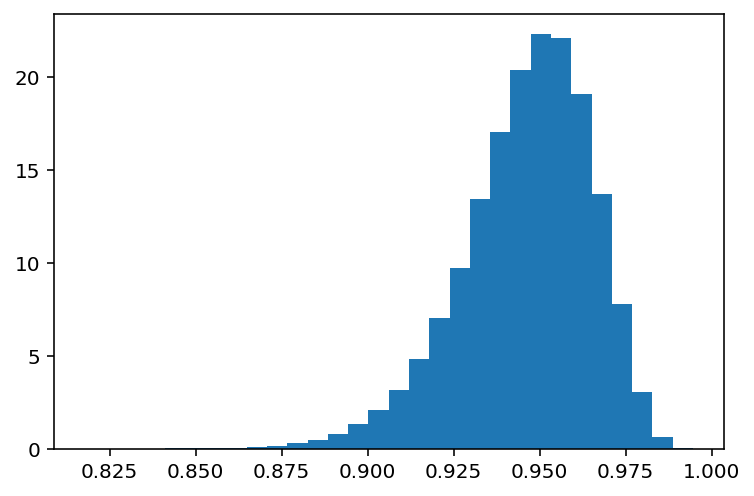

In [60]:
plt.hist(efficacy, bins=30, density=True)
plt.show()

In [61]:
# pfizer quoted a 95% interval of 90.3 to 97.6. Do we agree?
np.quantile(efficacy, [0.025, 0.975])

array([0.90335512, 0.97629549])

In [63]:
# pfizer quoted that the probability that the vaccine is at least 30% efficient is >99.99%. Do we agree?
np.mean(efficacy >= 0.30)

DeviceArray(1., dtype=float32)

#### How does the estimate change if we change the prior on the thetas to be uniform distributions?